# VaR and CVaR Calculation example

Taken from: https://pyquantnews.com/quickly-compute-value-at-risk-with-monte-carlo/


In [1]:
import numpy as np
import pandas as pd
from openbb import obb

sectors = [
    "XLE", 
    "XLF", 
    "XLU", 
    "XLI", 
    "GDX", 
    "XLK", 
    "XLV", 
    "XLY", 
    "XLP", 
    "XLB", 
    "XOP", 
    "IYR", 
    "XHB", 
    "ITB", 
    "VNQ", 
    "GDXJ", 
    "IYE", 
    "OIH", 
    "XME", 
    "XRT", 
    "SMH", 
    "IBB", 
    "KBE", 
    "KRE", 
    "XTL", 
]

data = obb.equity.price.historical(
    sectors, 
    start_date="2022-01-01", 
    provider="yfinance"
).to_df()

/var/folders/cy/q1_8g6sx22x91s9fdnd7mz1m0000gn/T/ipykernel_27572/748055163.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Extensions to add: federal_reserve@1.1.2, news@1.1.2, oecd@1.1.2, derivatives@1.1.2, fixedincome@1.1.2, crypto@1.1.2, polygon@1.1.2, etf@1.1.2, fred@1.1.2, benzinga@1.1.2, currency@1.1.2, tiingo@1.1.2, index@1.1.2, fmp@1.1.2, yfinance@1.1.2, tradingeconomics@1.1.2, economy@1.1.2, equity@1.1.2, intrinio@1.1.2, regulators@1.1.2, sec@1.1.2
Extensions to remove: fred@1.1.1, sec@1.1.1, etf@1.1.1, tradingeconomics@1.1.1, currency@1.1.1, federal_reserve@1.1.1, index@1.1.1, yfinance@1.1.1, economy@1.1.1, derivatives@1.1.1, equity@1.1.1, fmp@1.1.1, benzinga@1.1.1, fixedincome@1.1.1, news@1.1.1, oecd@1.1.1, tiingo@1.1.1, crypto@1.1.1, intrinio@1.1.1, polygon@1.1.1, regulators@1.1.1

Building...


/Users/bjoern/Library/Caches/pypoetry/virtualenvs/pyquanttest-h_uG_8tz-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/bjoern/Library/Caches/pypoetry/virtualenvs/pyquanttest-h_uG_8tz-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/Users/bjoern/Library/Caches/pypoetry/virtualenvs/pyquanttest-h_uG_8tz-py3.11/lib/python3.11/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h'

In [2]:
data


,open,high,low,close,volume,symbol,dividends,stock_splits,capital_gains
date,,,,,,,,,
2022-01-03,31.42,31.53,31.21,31.25,18828900,GDX,0.0,0.0,0.0
2022-01-03,41.27,41.49,40.95,41.03,6289900,GDXJ,0.0,0.0,0.0
2022-01-03,152.31,152.49,149.34,152.37,3753900,IBB,0.0,0.0,0.0
2022-01-03,83.04,83.04,80.20,80.69,3179600,ITB,0.0,0.0,0.0
2022-01-03,30.12,31.02,30.12,31.00,3693600,IYE,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
2024-02-16,179.31,180.07,177.92,179.02,4256100,XLY,0.0,0.0,0.0
2024-02-16,56.91,57.46,56.64,56.66,3097100,XME,0.0,0.0,0.0
2024-02-16,138.05,139.43,137.00,138.10,2661500,XOP,0.0,0.0,0.0


In [3]:
data.to_pickle("data.pkl")


In [4]:
data["returns"] = data.groupby("symbol").close.pct_change()

portfolio_stats = data.groupby("symbol").agg(
    daily_returns=("returns", "mean"),
)

portfolio_stats["weights"] = 1 / len(sectors)

covariance_matrix = (
    data
    .pivot(
        columns="symbol", 
        values="returns"
    )
    .dropna()
    .cov()
)


<Axes: xlabel='date'>

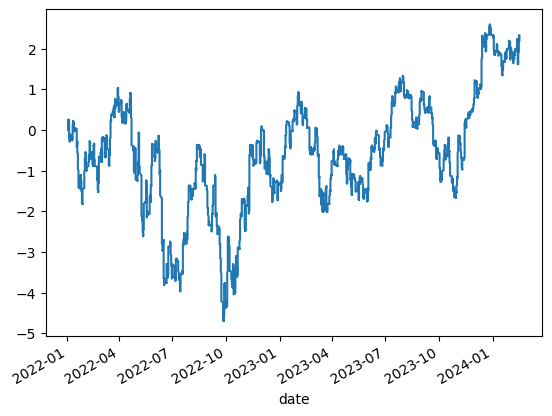

In [8]:
data.returns.cumsum().plot()

In [10]:
simulations = 1_000
days = len(data.index.unique())
initial_capital = 100_000

portfolio = np.zeros((days, simulations))

historical_returns = np.full(
    shape=(days, len(sectors)), 
    fill_value=portfolio_stats.daily_returns
)

In [11]:
L = np.linalg.cholesky(covariance_matrix)

for i in range(0, simulations):
    Z = np.random.normal(size=(days, len(sectors)))
    daily_returns = historical_returns + np.dot(L, Z.T).T
    portfolio[:, i] = (
        np.cumprod(np.dot(daily_returns, portfolio_stats.weights) + 1) * initial_capital
    )

simulated_portfolio = pd.DataFrame(portfolio)

With 80% probability the loss will not be greater than:
VaR:	81315.10
CVaR:	69177.03


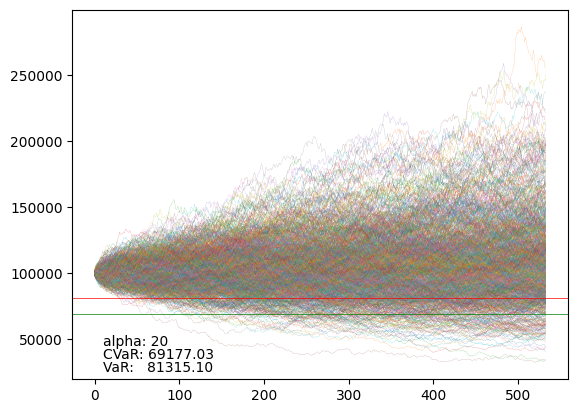

In [51]:
# alpha = 5
# alpha = 7.5
alpha = 20

def montecarlo_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return np.percentile(sim_val, alpha)

def conditional_var(alpha):
    sim_val = simulated_portfolio.iloc[-1, :]
    return sim_val[sim_val <= montecarlo_var(alpha)].mean()

mc_var = montecarlo_var(alpha)
cond_var = conditional_var(alpha)

ax = simulated_portfolio.plot(lw=0.1, legend=False)
ax.axhline(mc_var, lw=0.5, c="r")
ax.axhline(cond_var, lw=0.5, c="g")
ax.text(10,25000, f"VaR:   {mc_var:.2f}")
ax.text(10,35000, f"CVaR: {cond_var:.2f}")
ax.text(10,45000, f"alpha: {alpha}")

print(f"With {100-alpha}% probability the loss will not be greater than:")
print(f"VaR:\t{mc_var:6.2f}")
print(f"CVaR:\t{cond_var:6.2f}")


In [45]:
mc_var, cond_var

(81315.09744782418, 69177.03342377351)

In [46]:
fig = ax.get_figure()
fig.savefig("plot.png")